# Tabular Playground Series - Jun 2021

## Dependencies

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

SEED = 2502
DATA_PATH = "../data/tabular-playground-series-jun-2021/"

In [2]:
print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

PyTorch версия: 2.10.0+cu128
CUDA доступна: True
Используемое устройство: cuda


## Data

In [3]:
df_train = pd.read_csv(DATA_PATH + "train.csv")
df_test = pd.read_csv(DATA_PATH + "test.csv")

df_train['target'] = df_train['target'].str.replace("Class_", '').astype(int) - 1
df_train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,0,0,0,6,1,0,0,0,0,7,...,0,0,0,0,0,0,2,0,0,5
1,1,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,5
2,2,0,0,0,0,0,1,0,3,0,...,0,0,0,0,1,0,0,0,0,1
3,3,0,0,7,0,1,5,2,2,0,...,0,4,0,2,2,0,4,3,0,7
4,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### EDA

In [4]:
df_train.shape

(200000, 77)

200000 rows \
77 columns:
- 1 id
- 75 anonymized features
- 1 target (multiclass)

In [5]:
set(df_train.dtypes.values)

{dtype('int64')}

In [6]:
df_train.isna().sum().sum()

np.int64(0)

In [7]:
num_classes = df_train['target'].nunique()
num_classes

9

9 classes

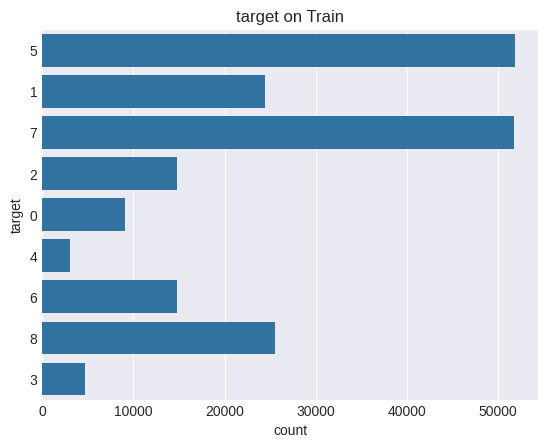

In [8]:
sns.countplot(df_train['target'].astype(str))
plt.title("target on Train")
plt.show()

### Dataset preparing

In [9]:
cols2drop = ['id']
target = 'target'
features = df_train.drop(columns=cols2drop + [target], errors='ignore').columns

X = df_train[features].to_numpy()
y = df_train[target].to_numpy()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

scaler_w = StandardScaler()
X_train = scaler_w.fit_transform(X_train)
X_val = scaler_w.transform(X_val)
X_test = scaler_w.transform(X_test)

In [11]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)
X_test_t = torch.FloatTensor(X_test)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=2**12, shuffle=True, num_workers=8)
val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=2**12, shuffle=False, num_workers=8)

## Model

In [12]:
class MultiClassClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiClassClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.network(x)

model = MultiClassClassifier(input_dim=X_train.shape[1], num_classes=num_classes).to(device)
print(model)

MultiClassClassifier(
  (network): Sequential(
    (0): Linear(in_features=75, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=9, bias=True)
  )
)


### Criterion & Optimizer

In [13]:
criterion_wine = nn.CrossEntropyLoss()
optimizer_wine = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

## Train

In [14]:
num_epochs = 150
train_losses_w, val_losses_w = [], []
train_accs_w, val_accs_w = [], []
best_val_acc = 0
patience_w, counter_w = 20, 0

for epoch in tqdm(range(num_epochs)):
    # Training
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        logits = model(X_batch)
        loss = criterion_wine(logits, y_batch)

        optimizer_wine.zero_grad()
        loss.backward()
        optimizer_wine.step()

        train_loss += loss.item()
        _, preds = torch.max(logits, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total
    train_losses_w.append(train_loss)
    train_accs_w.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            logits = model(X_batch)
            loss = criterion_wine(logits, y_batch)

            val_loss += loss.item()
            _, preds = torch.max(logits, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_losses_w.append(val_loss)
    val_accs_w.append(val_acc)

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter_w = 0
        torch.save(model.state_dict(), '../models/best_model.pth')
    else:
        counter_w += 1
        if counter_w >= patience_w:
            print(f"Early stopping на эпохе {epoch+1}")
            break

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

print(f"\nЛучшая val_acc: {best_val_acc:.4f}")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch  20 | Train Loss: 1.7949 Acc: 0.3473 | Val Loss: 1.7789 Acc: 0.3516
Epoch  40 | Train Loss: 1.7770 Acc: 0.3542 | Val Loss: 1.7694 Acc: 0.3535
Epoch  60 | Train Loss: 1.7700 Acc: 0.3558 | Val Loss: 1.7653 Acc: 0.3559
Epoch  80 | Train Loss: 1.7661 Acc: 0.3573 | Val Loss: 1.7642 Acc: 0.3576
Epoch 100 | Train Loss: 1.7607 Acc: 0.3591 | Val Loss: 1.7632 Acc: 0.3570


KeyboardInterrupt: 